In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-dgjgzisf
  Running command git clone -q https://github.com/aleju/imgaug /tmp/pip-req-build-dgjgzisf
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971106 sha256=373f84792e421f4a33e6aeddf7e37e383db44f942f30bd1721f3b1b180c2b000
  Stored in directory: /tmp/pip-ephem-wheel-cache-z5ukxhl3/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [3]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

In [4]:
batch_size = 64
learning_rate = 1e-3
IMAGE_SIZE = 224
NUM_CLASSES = 6

import PIL
import torchvision

transforms = ImgAugTransform()
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ASC/dataset/Binary dataset/Train', transform=transforms)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ASC/dataset/Binary dataset/Test', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.6/dist-packages/imgaug/imgaug.py:188: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)


In [5]:
import torchvision.models as models
import torch.nn as nn

googlenet = models.googlenet(pretrained=True)

for name,child in googlenet.named_children():
  print(name)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth



conv1
maxpool1
conv2
conv3
maxpool2
inception3a
inception3b
maxpool3
inception4a
inception4b
inception4c
inception4d
inception4e
maxpool4
inception5a
inception5b
avgpool
dropout
fc


In [6]:
#for name, child in googlenet.named_children():
  # if name in ['layer2','layer3', 'layer4']:
    #   print(name + ' is unfrozen')
    #   for param in child.parameters():
     #      param.requires_grad = True
 #  else:
     #  print(name + ' is frozen')
     #  for param in child.parameters():
        #   param.requires_grad = False

googlenet.last_linear = nn.Sequential(
    
nn.Linear(in_features=128, out_features=2),   )

googlenet = googlenet.cuda() if device else googlenet

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, googlenet.parameters()),lr=0.0006, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
#optimizer = optim.Adam(resnet50.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
use_cuda = torch.cuda.is_available()

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [9]:
n_epochs = 50
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = googlenet(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        googlenet.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = googlenet(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(googlenet.state_dict(), 'googlenet.pt')
            print('Improvement-Detected, save-model')
    googlenet.train()

Epoch 1

Epoch [1/50], Step [0/105], Loss: 7.7219
Epoch [1/50], Step [20/105], Loss: 0.6151
Epoch [1/50], Step [40/105], Loss: 0.3591
Epoch [1/50], Step [60/105], Loss: 0.5957
Epoch [1/50], Step [80/105], Loss: 0.3681
Epoch [1/50], Step [100/105], Loss: 0.6050

train-loss: 0.8649, train-acc: 80.3807
validation loss: 0.7739, validation acc: 65.6401

Improvement-Detected, save-model
Epoch 2

Epoch [2/50], Step [0/105], Loss: 0.3938
Epoch [2/50], Step [20/105], Loss: 0.4178
Epoch [2/50], Step [40/105], Loss: 0.2667
Epoch [2/50], Step [60/105], Loss: 0.2822
Epoch [2/50], Step [80/105], Loss: 0.3516
Epoch [2/50], Step [100/105], Loss: 0.2547

train-loss: 0.6135, train-acc: 85.6115
validation loss: 0.7374, validation acc: 68.1763

Improvement-Detected, save-model
Epoch 3

Epoch [3/50], Step [0/105], Loss: 0.4459
Epoch [3/50], Step [20/105], Loss: 0.4443
Epoch [3/50], Step [40/105], Loss: 0.2708
Epoch [3/50], Step [60/105], Loss: 0.3658
Epoch [3/50], Step [80/105], Loss: 0.2959
Epoch [3/50], 

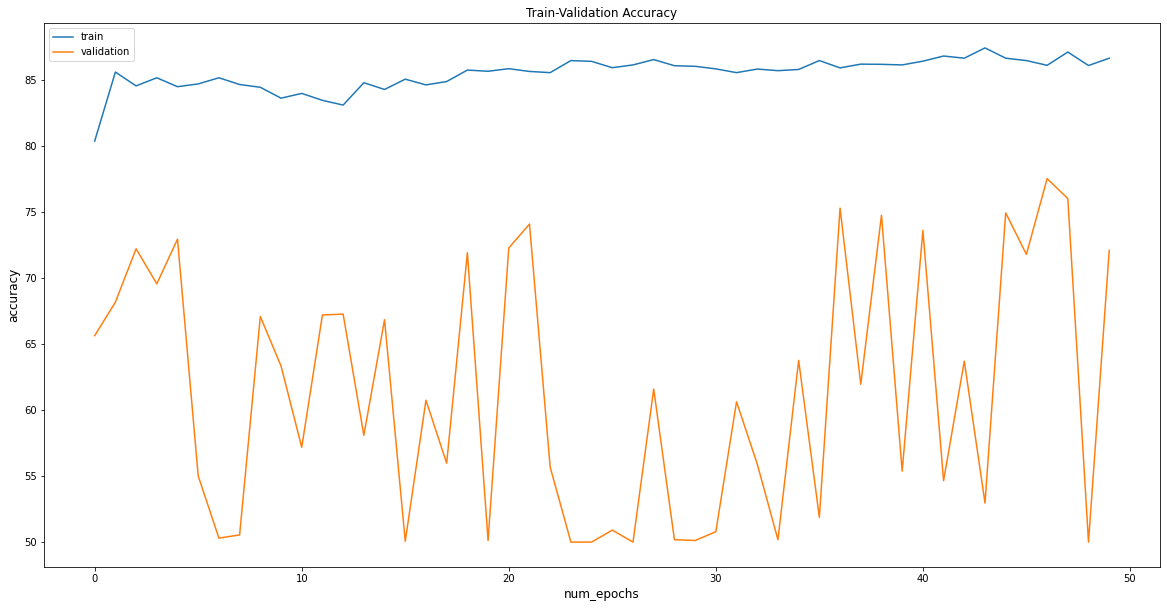

In [10]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')